In [1]:
from huggingface_hub import snapshot_download
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM
from datasets import load_dataset
import torch
import numpy as np
from trl import RewardTrainer, RewardConfig
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from data_preprocess import process_pairs_dataset
from config import MODEL_PATH, DATA_PATH, SEED, SCALAR_REWARD_MODEL_PATH, ALIGNED_OUTPUT_DIR
from data_preprocess import get_dataloaders

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 16
n_workers = 12

In [4]:
reward_model = AutoModelForSequenceClassification.from_pretrained(
    SCALAR_REWARD_MODEL_PATH,
    num_labels=1,
    local_files_only=True,
    device_map=device
)

reward_model.eval()

sft_model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    local_files_only=True,
    device_map=device
)

aligned_model = AutoModelForCausalLM.from_pretrained(
    ALIGNED_OUTPUT_DIR.format(level=1),
    local_files_only=True,
    device_map=device
) 

In [5]:
@torch.no_grad()
def evaluate(model, reward_model, dataloader, generation_kwargs):
  reward_history = []
  for batch in tqdm_notebook(dataloader, desc="Validation epoch"):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    generated = model.generate(input_ids=input_ids, attention_mask=attention_mask, **generation_kwargs)
    
    attention_mask_generated = (generated != reward_model.config.eos_token_id)
    reward = reward_model(input_ids=generated, attention_mask=attention_mask_generated).logits.squeeze(1)
    reward_history.extend(reward.detach().cpu().numpy().tolist())

  return reward_history

In [6]:
_, val_loader = get_dataloaders(DATA_PATH, batch_size, n_workers)

In [8]:
generation_kwargs_mnt32 = {"max_new_tokens": 32, "temperature": 1.0, "do_sample": True}
aligned_model_rewards_mnt32 = evaluate(aligned_model, reward_model, val_loader, generation_kwargs_mnt32)
sft_model_rewards_mnt32 = evaluate(sft_model, reward_model, val_loader, generation_kwargs_mnt32)

Validation epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Validation epoch:   0%|          | 0/24 [00:00<?, ?it/s]

In [12]:
def visualize(aligned_model_data, sft_model_data):
    mean_aligned = np.mean(aligned_model_data)
    mean_sft = np.mean(sft_model_data)
    
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(aligned_model_data, fill=True, label="Aligned Model")
    sns.kdeplot(sft_model_data, fill=True, label="SFT Model")
    
    plt.axvline(mean_aligned, color="blue", linestyle="--", label=f"Aligned mean: {mean_aligned:.2f}")
    plt.axvline(mean_sft, color="orange", linestyle="--", label=f"SFT mean: {mean_sft:.2f}")
    
    plt.grid(True)
    plt.legend()
    plt.title("Reward Distributions with Means")
    plt.xlabel("Reward")
    plt.ylabel("Density")

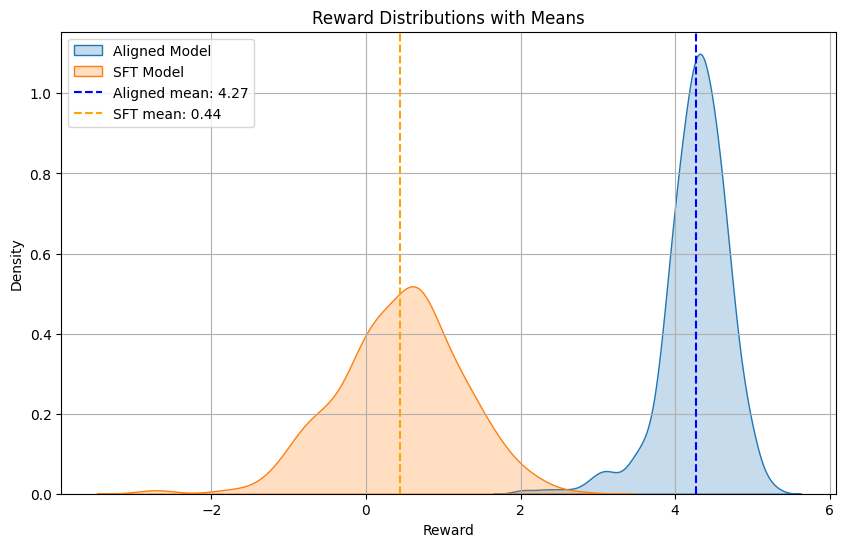

In [13]:
visualize(aligned_model_rewards_mnt32, sft_model_rewards_mnt32)

## Выводы по генерации на 32 токена

1. Распределение оценок для sft модели не является симметричным относительно, что скорее всего вызвано нецентрированием ревард модели.
2. Дообучение модели с помощью reinforce в постановке авторов оригинальной статьи привело к увеличению математического ожидания реварда.
3. Кроме увеличения средних значений, заметно уменьшилась дисперсия получаемых оценок, что еще раз подтверждает работоспособность метода

In [11]:
generation_kwargs = {"max_length": 512, "temperature": 1.0, "do_sample": True}
aligned_model_rewards = evaluate(aligned_model, reward_model, val_loader, get_reward_from_scalar_model, generation_kwargs)
sft_model_rewards = evaluate(sft_model, reward_model, val_loader, get_reward_from_scalar_model, generation_kwargs)

Validation epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Validation epoch:   0%|          | 0/24 [00:00<?, ?it/s]

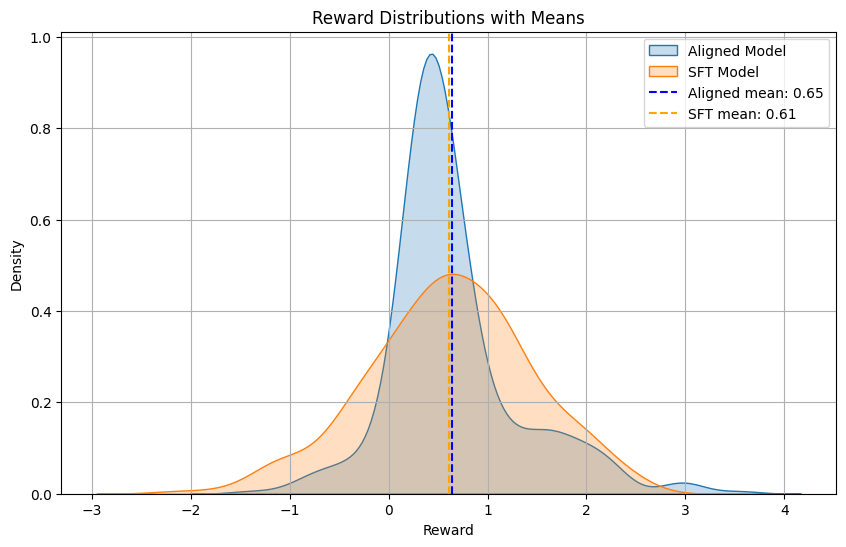

In [14]:
visualize(aligned_model_rewards, sft_model_rewards)

## Выводы по генерации на произвольное количество токенов

1. В отличие от предыдущего случая, значимого улучшения для дообученной модели не наблюдается
2. Средние значения получаемых ревардов остались неизменны
3. Дисперсия получаемых ответов уменьшилась, что говорит о том, что модель стала стала более "выровненной" вокруг некоторого среднего ответа

## Общие выводы

1. Метод как таковой продемонстрировал себя хорошо на той длине генерируемой последовательности, на которой модель училась (ожидаемый вывод)
2. Генерация большого ответа и хранение градиентов для всех этапов генерации является достаточно требовательной к ресурсам задачей, что ограничивает применение метода. Как стало видно, при обучении модели на небольшой длине общее качество ответов не становится лучше с точки зрения ревардов, но это делает модель более "стабильной". Я думаю, это происходит потому, что ответ модели во многом определяется именно первыми токенами, которые модель умеет генерировать "лучше".